In [1]:
import glob
import os
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline

In [2]:
# CAM output files
FILES = {
    'CNT': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.06/atm/hist/*.h0.*.nc")),
    'SAI20': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/atm/hist/*.h0.*.nc"))[:-12] # last 12 months also in extension
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/atm/hist/*.h0.*.nc")),
    'SAI80': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/atm/hist/*.h0.*.nc"))
}

# stratospheric forcing files
STFILES = {
    'SAI20': '/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2100_SSP585_CAMfeedback-2100.nc',
    'SAI20E': '/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2150_SSP585_CAMfeedback-2131.nc',
    'SAI80': '/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2150_SSP585_CAMfeedback.nc',
}

In [3]:
# Check if number of months is OK
print(np.array([f.split('.')[-2] for f in FILES['CNT']])[[0,-1]])
print('CNT',(131-15)*12, len(FILES['CNT']))
print(np.array([f.split('.')[-2] for f in FILES['SAI20']])[[0,-1]])
print('SAI20',(131-45)*12, len(FILES['SAI20']))
print(np.array([f.split('.')[-2] for f in FILES['SAI80']])[[0,-1]])
print('SAI80',(131-80)*12, len(FILES['SAI80']))

['2015-01' '2130-12']
CNT 1392 1392
['2045-01' '2130-12']
SAI20 1032 1032
['2080-01' '2130-12']
SAI80 612 612


In [4]:
%%time
# Open CAM datasets
# This is a workaround for xr.open_mfdataset, which is very slow for our data
def open_dataset(file):
    ds = xr.open_dataset(file)
    try:
        ds = ds[['AODVISstdn','time_bnds','gw']]
    except KeyError: # no AODVISstdn in SAI20
        ds = ds[['time_bnds','gw']]
    # running concat here will make the final concat way faster!
    return xr.concat((ds,), dim='time') 

def parallel_open(files):
    with mp.Pool(processes=16) as pool:
        fh = pool.map(open_dataset, files)
    return xr.concat(fh, dim='time')

if __name__ == '__main__':
    ds = {k: parallel_open(FILES[k]) for k in FILES}

CPU times: user 2.96 s, sys: 1.01 s, total: 3.97 s
Wall time: 49.8 s


In [5]:
# open strataero forcing files
stds = {k: xr.open_dataset(STFILES[k]) for k in STFILES}

In [6]:
%%time
# compute annual mean global mean AOD
AOD = {k: ds[k].AODVISstdn.weighted(ds[k].gw).mean(('lat','lon')).coarsen(time=12).mean().compute() for k in ds}
stAOD = {k: stds[k].AODVISstdn.weighted(stds[k].gw).mean(('lat')) for k in stds}
for k in stAOD:
    stAOD[k].data[stAOD[k]==0] = np.nan
stAOD = {k: stAOD[k].groupby('time.year').mean().assign_coords(time=stAOD[k].time.groupby('time.year').mean()).swap_dims({'year':'time'}) for k in stAOD}

CPU times: user 1.22 s, sys: 474 ms, total: 1.7 s
Wall time: 3.42 s


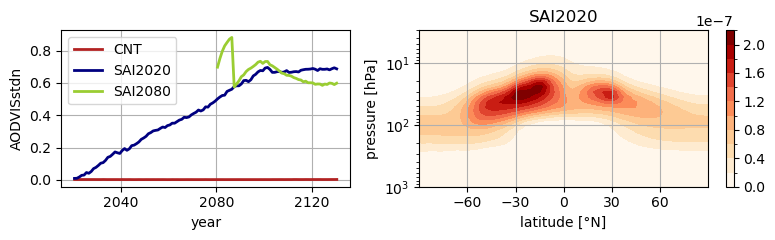

In [60]:
fig, ax = plt.subplots(1,2, figsize=(8,2.5), width_ratios=[1,1.25])
AOD['CNT'].sel(time=slice('2020','2130')).plot(ax=ax[0], c='firebrick', lw=2, label='CNT')
(stAOD['SAI20E']).sel(time=slice('2020','2130')).plot(ax=ax[0], c='navy', lw=2, label='SAI2020')
(stAOD['SAI80']).sel(time=slice('2080','2130')).plot(ax=ax[0], c='yellowgreen', lw=2, label='SAI2080')
ax[0].legend(loc='upper left')
ax[0].set_xlabel('year')
ax[0].grid()

so4mass = stds['SAI20'].so4mass_a1+stds['SAI20'].so4mass_a2+stds['SAI20'].so4mass_a3
so4mass = so4mass.sel(time=slice('2020','2130')).mean('time').isel(lev=slice(25,70))
so4mass.plot.contourf(ax=ax[1], yscale='log', cmap='OrRd', vmin=0, levels=np.arange(0,2.25e-7,0.2e-7))
ax[1].invert_yaxis()
ax[1].set_ylim([1000,3])
ax[1].set_ylabel('pressure [hPa]')
ax[1].set_xlabel('latitude [°N]')
ax[1].set_xticks(range(-60,61,30))
ax[1].grid()
ax[1].set_title('SAI2020')
p2.colorbar.ax.set_ylabel(f"SO4 conc. [{stds['SAI20'].so4mass_a3.units}]")


plt.tight_layout()
fig.savefig('aod_so4mass.pdf')